In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from tqdm.notebook import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import random
import torch
import cv2
import os

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    dataset_path = "/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/"
    test_image_path = os.path.join(dataset_path, "test")
    sample_sub_path = os.path.join(dataset_path, "sample_submission.csv")

    checkpoint_path = "/kaggle/input/byu-2025-faster-r-cnn-1-2-training/faster_rcnn_R_50_FPN_3x_fold_0/best_checkpoint.pth"
    model_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"

    confidence_threshold = 0.8
    nms_iou_threshold = 0.5
    seed = 42

In [3]:
random.seed(CFG.seed)
np.random.seed(CFG.seed)
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(CFG.model_name))

cfg.MODEL.WEIGHTS = CFG.checkpoint_path
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [5]:
def perform_3d_nms(detections, distance_threshold=CFG.nms_iou_threshold):
    if not detections:
        return []

    detections = sorted(detections, key=lambda x: x['confidence'], reverse=True)
    final_detections = []

    def distance_3d(d1, d2):
        return np.sqrt((d1['z'] - d2['z'])**2 + (d1['y'] - d2['y'])**2 + (d1['x'] - d2['x'])**2)

    while detections:
        best_detection = detections.pop(0)

        final_detections.append(best_detection)

        detections = [d for d in detections if distance_3d(d, best_detection) > distance_threshold]
        
    return final_detections

In [6]:
def predict_motors_in_tomogram(tomo_id, predictor):
    tomo_path = os.path.join(CFG.test_image_path, str(tomo_id))    
    slices = sorted([f for f in os.listdir(tomo_path) if f.endswith('.jpg')])
    if not slices:
        return None, 0
    
    all_detections = []
    for z, slice_file in enumerate(slices):
        slice_path = os.path.join(tomo_path, slice_file)
        img = cv2.imread(slice_path)
        
        outputs = predictor(img)
        instances = outputs["instances"].to("cpu")
        boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else []
        scores = instances.scores.numpy() if instances.has("scores") else []
        
        for box, score in zip(boxes, scores):
            if score > CFG.confidence_threshold:
                x_center = (box[0] + box[2]) / 2
                y_center = (box[1] + box[3]) / 2
                all_detections.append({
                    'z': z,
                    'y': y_center,
                    'x': x_center,
                    'confidence': score
                })

    all_detections = perform_3d_nms(all_detections)
    if not all_detections:
        return [-1, -1, -1], 0
    
    all_detections.sort(key=lambda x: x['confidence'], reverse=True)
    best_detection = all_detections[0]
    
    motor_position = [
        int(best_detection['z']),
        int(best_detection['y']),
        int(best_detection['x'])
    ]
    
    return motor_position, float(best_detection['confidence'])

In [7]:
def generate_predictions(test_dir, predictor):
    predictions = []
    
    tomo_ids = [d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))]
    for tomo_id in tqdm(tomo_ids):
        motor_position, confidence = predict_motors_in_tomogram(tomo_id, predictor)        
        predictions.append({
            'tomo_id': tomo_id,
            'Motor axis 0': motor_position[0],
            'Motor axis 1': motor_position[1],
            'Motor axis 2': motor_position[2],
            'Confidence': confidence,
            'Has motor': 1 if motor_position[0] != -1 else 0
        })
    
    return pd.DataFrame(predictions)

In [8]:
predictor = DefaultPredictor(cfg)

In [9]:
%%time
test_preds = generate_predictions(CFG.test_image_path, predictor)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 1min 50s, sys: 1.02 s, total: 1min 51s
Wall time: 1min 45s


In [10]:
sub = pd.read_csv(CFG.sample_sub_path)
sub = test_preds[['tomo_id', 'Motor axis 0', 'Motor axis 1', 'Motor axis 2']]
sub.to_csv("submission.csv", index=False)
sub.head()

,tomo_id,Motor axis 0,Motor axis 1,Motor axis 2
0,tomo_01a877,148,637,284
1,tomo_00e047,170,540,608
2,tomo_003acc,-1,-1,-1


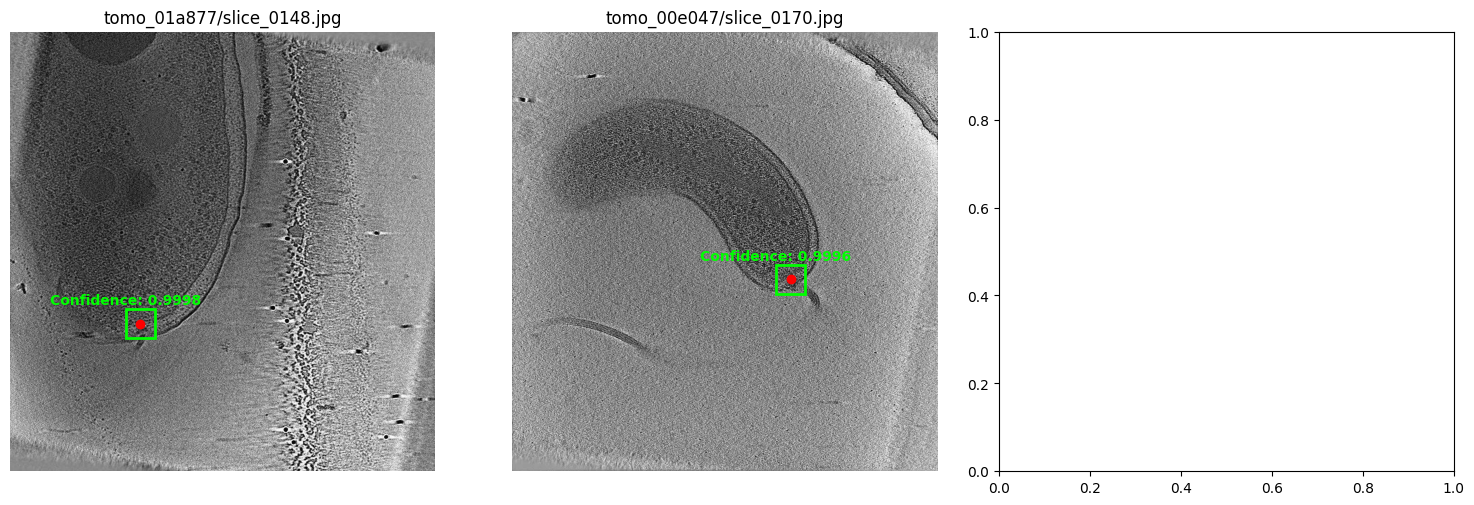

In [11]:
if len(test_preds) == 3:
    points = []
    image_paths = []
    
    for i, r in test_preds.iterrows():
        if (
            r['Motor axis 0'] != -1 and 
            r['Motor axis 1'] != -1 and 
            r['Motor axis 2'] != -1
        ):
            slice_num = int(r['Motor axis 0'])
            slice_str = f"{slice_num:04d}"
            image_path = f"/kaggle/input/byu-locating-bacterial-flagellar-motors-2025/test/{r.tomo_id}/slice_{slice_str}.jpg"
            image_paths.append(image_path)
            points.append((r['Motor axis 2'], r['Motor axis 1'], r['Confidence']))

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    box_size = 64
    half_box = box_size // 2

    for i, path in enumerate(image_paths):
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        x, y, confidence = points[i]
        
        axes[i].scatter(x, y, color="red")
        
        rect = patches.Rectangle((x - half_box, y - half_box), box_size, box_size, linewidth=2, edgecolor='lime', facecolor='none')
        axes[i].add_patch(rect)
        
        axes[i].text(x - half_box, y - half_box - 10, f"Confidence: {confidence:.4f}", color='lime', fontsize=10, weight='bold', ha='center')
        axes[i].set_title(path.split("/")[-2] + "/" + path.split("/")[-1])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()